In [ ]:
import os
import time
import uuid
import cv2

In [ ]:
images_path = os.path.join('data','images')
number_images = 30

In [ ]:
cap = cv2.VideoCapture(0)
for imgnum in range (number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(images_path, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep (0.5)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [9]:
!labelme

2024-03-30 20:53:50,557 [INFO   ] __init__:get_config:67- Loading config file from: /Users/maniksinghsarmaal/.labelmerc
^C


In [10]:
import tensorflow as tf
import json
from matplotlib import pyplot as plt
import numpy as np

In [14]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [11]:
tf.config.list_physical_devices('GPU' )

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [18]:
images = tf.data.Dataset.list_files('data/images/*.jpg', shuffle=False)

In [21]:
images.as_numpy_iterator().next()

b'data/images/323daa9e-eea9-11ee-af56-a6cd0eba30f1.jpg'

In [22]:
def load_image(x):
    byte_image = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_image)
    return img

In [23]:
images = images.map(load_image)

In [24]:
images.as_numpy_iterator().next()

array([[[32, 33, 35],
        [26, 27, 29],
        [19, 23, 24],
        ...,
        [29, 34, 30],
        [29, 34, 30],
        [24, 29, 25]],

       [[23, 24, 26],
        [28, 29, 31],
        [38, 42, 43],
        ...,
        [36, 41, 37],
        [32, 37, 33],
        [24, 29, 25]],

       [[26, 27, 29],
        [28, 29, 31],
        [31, 35, 36],
        ...,
        [34, 40, 38],
        [25, 30, 26],
        [22, 27, 23]],

       ...,

       [[ 1,  1,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 4,  4,  4],
        [14, 14, 14],
        [21, 21, 21]],

       [[ 0,  0,  0],
        [ 2,  2,  0],
        [ 0,  0,  0],
        ...,
        [ 9,  9,  9],
        [ 9,  9,  9],
        [14, 14, 14]],

       [[ 0,  0,  0],
        [ 3,  3,  1],
        [ 0,  0,  0],
        ...,
        [ 6,  6,  6],
        [10, 10, 10],
        [12, 12, 12]]], dtype=uint8)

In [35]:
image_generator = images.batch(4).as_numpy_iterator()
plot_images = image_generator.next()

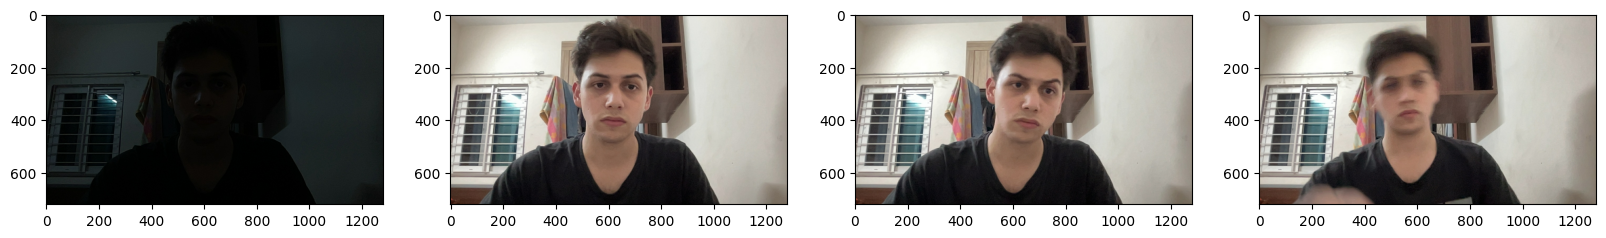

In [36]:
fig,ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

In [ ]:
#manually train test valid split

In [37]:
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        filename = file.split('.')[0]+'.json' 
        existing_filepath = os. path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join( 'data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)

In [44]:
import albumentations as alb
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
alb.HorizontalFlip(p=0.5),
alb.RandomBrightnessContrast(p=0.2),
alb. RandomGamma (p=0.2), alb.RGBShift(p=0.2),
alb. VerticalFlip(p=0.5)],bbox_params=alb.BboxParams(format='albumentations',
label_fields=['class_labels']))

In [94]:
#random image
img =cv2.imread('/Users/maniksinghsarmaal/Downloads/Computer_Vision/Projects/facedet/data/train/images/85649ee0-eea8-11ee-af56-a6cd0eba30f1.jpg')
img.shape

(720, 1280, 3)

In [95]:
with open(os.path.join('data','train','labels','85649ee0-eea8-11ee-af56-a6cd0eba30f1.json'), 'rb') as f:
    label=json.load(f)

In [96]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [97]:
coords

[431.86046511627904, 276.8604651162791, 779.5348837209302, 673.3720930232558]

In [98]:
coords = list(np.divide(coords,[1280,720,1280,720]))

In [99]:
coords

[0.337390988372093, 0.3845284237726099, 0.6090116279069767, 0.9352390180878554]

In [100]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [101]:
augmented['image'].shape

(450, 450, 3)

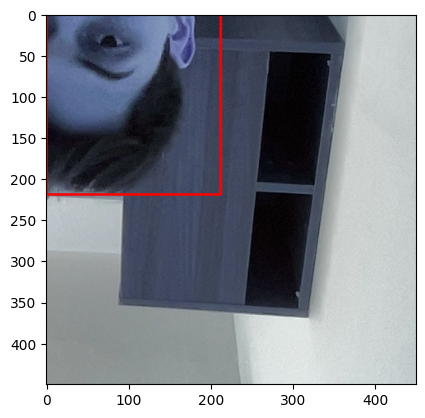

In [102]:
cv2.rectangle(augmented['image'],
tuple(np.multiply(augmented['bboxes'][0][:2],
[450,450]).astype(int)),
tuple(np.multiply(augmented['bboxes'][0][2:],
[450,450]).astype(int)),
(255,0,0), 2)
plt. imshow(augmented [ 'image'])

In [104]:
for partition in ['train', 'test', 'val']:
    for image in os.listdir(os.path.join('data', partition,'images')):
        img = cv2.imread(os.path.join('data', partition,'images', image))
        
        coords = [0,0,0.00001,0.00001]
        label_path= os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
                
            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide (coords,[1280,720,1280,720]))
        
        try:
            for x in range(60): #we are creating 60 augmented images per single image
                augmented =augmentor(image=img,bboxes=[coords],class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images',f'{image.split(".")[0]}.{x}.jpg'),augmented['image'])
                annotation ={}
                annotation['image']=image
                
                if os.path.exists(label_path):
                    if len(augmented['bboxes'])==0:
                        annotation['bboxes'] = [0,0,0,0]
                        annotation['class'] = 0
                    else:
                        annotation['bboxes']= augmented['bboxes'][0]
                        annotation['class']=1
                else:
                    annotation['bboxes'] = [0,0,0,0]
                    annotation['class'] = 0
                    
                with open(os.path.join('aug_data',partition,'labels',f'{image.split(".")[0]}.{x}.json'),'w') as f:
                    json.dump(annotation,f)
        except Exception as e:
            print(e)

image must be numpy array type


In [134]:
#loading augmented images to tensorflow dataset
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg',shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x,(120,120)))
train_images = train_images.map(lambda x: x/255)


In [135]:
#loading augmented images to tensorflow dataset
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg',shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x,(120,120)))
test_images = test_images.map(lambda x: x/255)


In [136]:
#loading augmented images to tensorflow dataset
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg',shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x,(120,120)))
val_images = val_images.map(lambda x: x/255)


prepare labels


In [158]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding='utf-8') as f:
        label = json.load(f)
    return [label['class']], label['bbox']

In [159]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels,[x],[tf.uint8, tf.float16]))

In [160]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels,[x],[tf.uint8, tf.float16]))

In [161]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels,[x],[tf.uint8, tf.float16]))

checking consisitency of aug_data laoded properly into the train_images

In [162]:
len(train_images),len(train_labels), len(test_images),len(test_labels), len(val_images),len(val_labels)

(3780, 3780, 840, 840, 780, 780)

Create a Final Dataset


In [164]:
train = tf.data.Dataset.zip((train_images,train_labels))
train = train.shuffle(4000)
train = train.batch(8) #Batch Size
train = train.prefetch(4) #eliminates bottleneck

In [165]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [166]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [ ]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding='utf-8') as f:
        label = json.load(f)
        print(f'keys in label: {label.keys()}')
    return [label['class']], label['bbox']

In [ ]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding='utf-8') as f:
        label = json.load(f)
        print(f'keys in label: {label.keys()}')
    return [label['class']], label['bbox']

In [ ]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding='utf-8') as f:
        label = json.load(f)
        print(f'keys in label: {label.keys()}')
    return [label['class']], label['bbox']

In [ ]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding='utf-8') as f:
        label = json.load(f)
        print(f'keys in label: {label.keys()}')
    return [label['class']], label['bbox']

In [ ]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding='utf-8') as f:
        label = json.load(f)
        print(f'keys in label: {label.keys()}')
    return [label['class']], label['bbox']

In [ ]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding='utf-8') as f:
        label = json.load(f)
        print(f'keys in label: {label.keys()}')
    return [label['class']], label['bbox']

In [ ]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding='utf-8') as f:
        label = json.load(f)
        print(f'keys in label: {label.keys()}')
    return [label['class']], label['bbox']

In [ ]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding='utf-8') as f:
        label = json.load(f)
        print(f'keys in label: {label.keys()}')
    return [label['class']], label['bbox']

In [ ]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding='utf-8') as f:
        label = json.load(f)
        print(f'keys in label: {label.keys()}')
    return [label['class']], label['bbox']

In [ ]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding='utf-8') as f:
        label = json.load(f)
        print(f'keys in label: {label.keys()}')
    return [label['class']], label['bbox']